In [2]:
from typing import List, Dict, Set, Tuple, Optional
import numpy as np
import cv2
import itertools
import random
import copy 
import matplotlib.pyplot as plt
from utils import Path
from tqdm import tqdm
import collections

import elkai
from tsp_solver.greedy import solve_tsp
from python_tsp.exact import solve_tsp_dynamic_programming
import time 

In [14]:
class ThreeOpt(Path):
    def __init__(self,
        image: np.ndarray,
        patch_size: Tuple[int,int],
        start: int,
        iteration: int = 1,
        threshold: float = 0.01,
        verbose: Optional[bool] = True):
            
        super().__init__(image,patch_size,verbose)
        self.start = start
        self.iteration = iteration
        self.threshold = threshold
        self.history = [[] for _ in range(self.iteration)]

    def get_statistics(self):
        """
        Plot the statistics of 3-opt
        """
        self.history = np.asarray(self.history)
        plt.figure(figsize=(15,10))
        ax = plt.subplot(111)
        for i in range(self.iteration):
            ax.plot(np.arange(self.history.shape[1]),self.history[i,:],label=f"route {i}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0+box.height*0.1,box.width,box.height*0.9]) # shrink axis height by 10%
        ax.legend(loc="upper center", bbox_to_anchor=(0.5,-0.05),fancybox=True,shadow=True,ncol=self.iteration//2)
        ax.set_title("3 Opt")
        ax.set_ylabel("Distance")
        ax.set_xlabel("Iteration")
        plt.show()

    def initialize(self):
        route = [self.start]
        route += random.sample(range(1,self.num_vertex), self.num_vertex-1)
        
        return route
    
    def get_distance(self,route):
        dist = 0
        for i in range(self.num_vertex-1):
            dist += self.weight_matrix[route[i],route[i+1]]
            
        return dist

    def exchange(self,route,case,a,c,e):
            """ 
            Three opt exchange, 
            """
            b,d,f = a+1, c+1, e+1
            p_a,p_b,p_c,p_d,p_e,p_f = [route[i] for i in [a,b,c,d,e,f]]
            base = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_d] + self.weight_matrix[p_e][p_f]
    
            if case == 1:
                # 2-opt A'BC
                path = route[:a+1] + route[e:d-1:-1] + route[c:b-1:-1] + route[f:]
                cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_c][p_d] + self.weight_matrix[p_b][p_f]

            elif case == 2:
                # 2-opt ABC'
                path = route[:a+1] + route[c:b-1:-1] + route[d:e+1] + route[f:]
                cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_e][p_f]

            elif case == 3:
                # 2-opt AB'C
                path = route[:a+1] + route[b:c+1] + route[e:d-1:-1] + route[f:]
                cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_e] + self.weight_matrix[p_d][p_f]

            elif case == 4:
                # 3-opt AB'C'
                path = route[:a+1] + route[c:b-1:-1] + route[e:d-1:-1] + route[f:]
                cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_e] + self.weight_matrix[p_d][p_f]

            elif case == 5:
                # 3-opt A'B'C
                path = route[:a+1] + route[d:e+1] + route[c:b-1:-1] + route[f:]
                cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_b][p_f] + self.weight_matrix[p_c][p_e]

            elif case == 6:
                # 3-opt A'BC'
                path = route[:a+1] + route[e:d-1:-1] + route[b:c+1] + route[f:]
                cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_c][p_f]

            elif case == 7:
                # 3-opt A'B'C'
                path = route[:a+1] + route[d:e+1] + route[b:c+1] + route[f:]
                cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_b][p_e] + self.weight_matrix[p_c][p_f]

            duplicates = [item for item, count in collections.Counter(path).items() if count > 1]
            if len(duplicates) != 0:
                print(duplicates)
                
            assert len(duplicates) == 0, f"Case {case}: path change error"

            return path, base-cost
    
    def three_opt(self,
                  route: List[int],
                  num_iteration: Optional[int] = None):

        iteration = 0
        for a in tqdm(range(0,self.num_vertex-5)):
            for c in range(a+2,len(route)-3):
                for e in range(c+2,len(route)-1):
                    temp_route = copy.deepcopy(route)
                    best_change = 0
                    for i in range(1,8):
                        path,change = self.exchange(temp_route,i,a,c,e)
                        if change > best_change:
                            route = path
                            best_change = change
            
                        if not (num_iteration == None):
                            if iteration == num_iteration:
                                return route
                            else:
                                iteration += 1


        return route

    def _optimize(self):
        self.seal_path = []
        self.traverse_path = []
        self.all_path_converted = []   
        for i, g in enumerate(self.all_graphs):
            route = self.initialize()
            path = self.three_opt(route)
            path = self.build_path(path,self.adj_list,self.local_to_coords)
            self.seal_path.append(path)

        if len(self.seal_path) == 1:
            p = [self.mapping_r[local_node] for local_node in self.seal_path[0]]
            self.all_path_converted.append(p)
            return p
        
        else:
            path = []
            path_weights, connect_paths = self.post_path(self.seal_path)
            path_weights[:,0] = 0
            crack_order, _ = solve_tsp_dynamic_programming(path_weights)
            self.all_path_converted = []        

            for i in range(len(self.all_graphs)):
                path_converted = []
                path_converted = list(map(lambda x : self.mapping_r[x], self.seal_path[i]))
                self.all_path_converted.append(path_converted)

            path = []
            for i in range(len(self.all_path_converted)-1):
                path.extend(self.all_path_converted[i])
                traverse_path = connect_paths[(i,i+1)]
                path.extend(traverse_path)
                self.traverse_path.append(traverse_path)

            path.extend(self.all_path_converted[crack_order[-1]])

            return path

Preprocessing of graph completed


  0%|          | 0/109 [00:00<?, ?it/s]

100%|██████████| 109/109 [00:28<00:00,  3.79it/s]


[1174, 1175, 1235, 1175, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1302, 1303, 1304, 1305, 1306, 1366, 1367, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1377, 1378, 1438, 1439, 1379, 1378, 1377, 1376, 1375, 1374, 1314, 1313, 1253, 1252, 1251, 1250, 1310, 1309, 1308, 1307, 1306, 1305, 1304, 1303, 1302, 1301, 1300, 1299, 1298, 1297, 1296, 1295, 1294, 1234, 1233, 1293, 1292, 1291, 1231, 1232, 1231, 1230, 1290, 1289, 1229, 1228, 1288, 1348, 1288, 1287, 1347, 1346, 1406, 1346, 1345, 1405, 1404, 1464, 1463, 1462, 1461, 1460, 1400, 1399, 1398, 1458, 1457, 1456, 1455, 1454, 1453, 1452, 1451, 1391, 1390, 1389, 1388, 1387, 1386, 1385, 1384, 1383, 1443, 1442, 1441, 1440, 1500, 1501, 1441, 1442, 1443, 1444, 1445, 1385, 1386, 1387, 1388, 1389, 1449, 1450, 1451, 1452, 1512, 1513, 1514, 1454, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404]
114
272 152 192 184
(147, 33, 0)


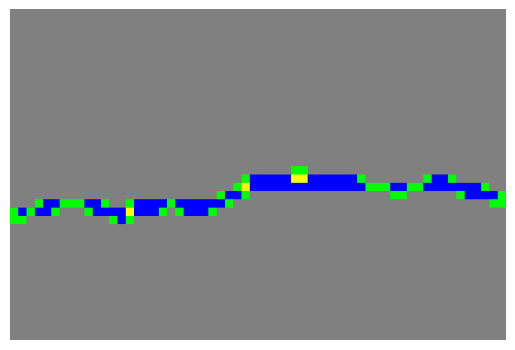

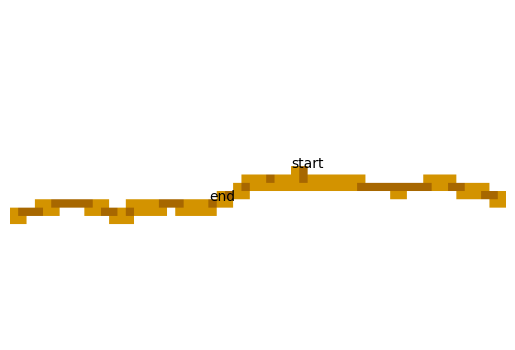

In [15]:
if __name__ == "__main__":

    img = cv2.imread("./binary_image/4.png",cv2.IMREAD_UNCHANGED) 
    ps = (8,8)
    x = ThreeOpt(img,ps,0,1,0.01,True)
    path = x._optimize()  
    print(path)
    print(x.num_vertex)
    print(x.check_all_path())
    # x.get_statistics()